In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Open images

In [99]:
img_input_0 = cv2.imread("C:/Users/edmundo/Downloads/ps1_matlab_template/input/ps1-input0.png")
img_input_0_noise = cv2.imread("C:/Users/edmundo/Downloads/ps1_matlab_template/input/ps1-input0-noise.png")

# Plot original images
## Swap red and blue planes as opencv is bgr and matplotlib expects rgb

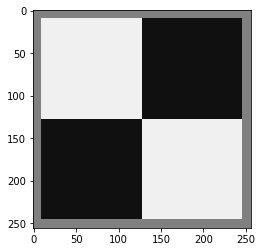

In [100]:
b,g,r = cv2.split(img_input_0)
img_input_0 = cv2.merge([b,g,r])
plt.imshow(img_input_0)

# Generate edge image

In [101]:
img_edge = cv2.Canny(img_input_0, 100, 200)

# Plot edge image

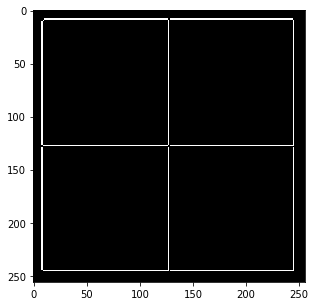

In [102]:
plt.subplots(figsize=(5, 5))
plt.imshow(img_edge, cmap='gray')

# We define a Hough transform function

In [124]:
def hough_lines_acc(img_edges, original_image):
    height, width = img_edges.shape[:2]
    
    # Compute maximum and minimum rho
    max_rho_at = np.arctan(-height/width)
    max_rho = abs(width * np.cos(max_rho_at) - height * np.sin(max_rho_at))
    min_rho = -max_rho
    
    # Compute gradient with Sobel
    kernel_x = np.ones((3,3),np.float32)
    kernel_x[0] = [-1, 0, 1]
    kernel_x[1] = [-2, 0, 2]
    kernel_x[2] = [-1, 0, 1]
    
    kernel_y = np.ones((3,3),np.float32)
    kernel_y[0] = [1, 2, 1]
    kernel_y[1] = [0, 0, 0]
    kernel_y[2] = [-1, -2, -1]
    
    partial_x = cv2.filter2D(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), -1, kernel_x)
    partial_y = cv2.filter2D(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), -1, kernel_y)
    
    #partial_x = cv2.filter2D(img_edges, -1, kernel_x)
    #partial_y = cv2.filter2D(img_edges, -1, kernel_y)
         
    # Initialize the accumulator h(rho, theta)
    h = np.zeros((int(max_rho*2) +1 , 180+1), dtype=np.uint8)
    
    """
    for y,x in np.ndindex(img_edges.shape):
        if img_edges[y][x]:
            for i in range(0, 180):
                rad = i*(np.pi/180)
                rho = x*np.cos(rad)+y*np.sin(rad)
                h[int(rho+max_rho)][i] += 1
    
    """
    """
    for y,x in np.ndindex(img_edges.shape):
        if img_edges[y][x]:
            if partial_x[y][x] == 0:
                theta = 90
                rad = theta*(np.pi/180)
            else:
                rad = np.arctan(partial_y[y][x] / partial_x[y][x])
                theta = rad*(180/np.pi)
                
                if theta > 180:
                    theta -= 180
                    rad -= np.pi
                               
            rho = x*np.cos(rad)+y*np.sin(rad)
            h[int(rho+max_rho)][int(round(theta))] += 1
    """
    for y,x in np.ndindex(img_edges.shape):
        if img_edges[y][x]:
            if partial_x[y][x] == 0:
                theta = 90
            else:
                rad = np.arctan(partial_y[y][x] / partial_x[y][x])
                theta = rad*(180/np.pi)
                
                if theta > 180:
                    theta -= 180
                    rad -= np.pi
            
            for theta_calc in range(int(theta), int(theta)+180):
                if theta_calc > 180:
                    theta_calc -= 180
                rad_calc = theta_calc*(np.pi/180)
                rho = x*np.cos(rad_calc)+y*np.sin(rad_calc)
                h[int(rho+max_rho)][int(round(theta_calc))] += 1
            
    return h

In [125]:
h = hough_lines_acc(img_edge, img_input_0)

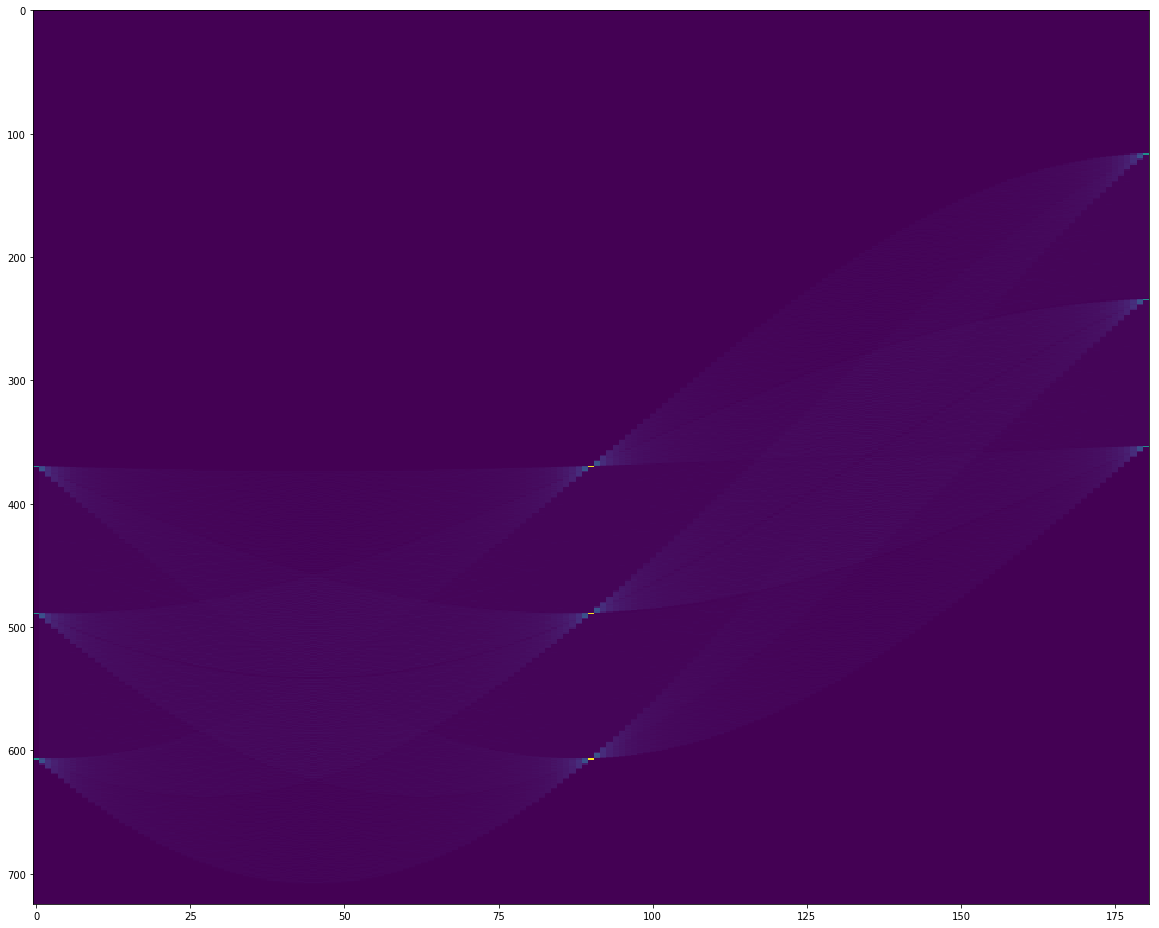

In [126]:
plt.subplots(figsize=(20, 20))
plt.imshow(h, aspect=0.2)

# This is the function hough_peaks to find biggest k peaks

In [127]:
def hough_peaks(h, numpeaks):
    return np.unravel_index(np.argsort(h.ravel())[-numpeaks:], h.shape)

In [132]:
peaks = hough_peaks(h, 10)
print(peaks)

(array([492, 354, 370, 489, 117, 607, 235, 370, 489, 607], dtype=int64), array([  1, 180,   0,   0, 180,   0, 180,  90,  90,  90], dtype=int64))


# This is the function to draw the lines

In [133]:
def hough_lines_draw(img, peaks, max_rho):
    result_image = np.copy(img)
    
    for index,item in enumerate(peaks[0]):
        rho = item-max_rho
        a = np.cos(peaks[1][index]*np.pi/180)
        b = np.sin(peaks[1][index]*np.pi/180)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        
        cv2.line(result_image,(x1,y1),(x2,y2),(0,255,0),2)
    
    return result_image

In [134]:
result_image = hough_lines_draw(img_input_0, peaks, int(h.shape[0]/2))

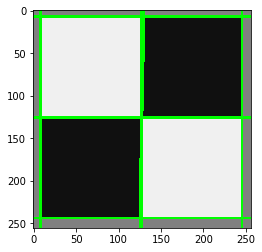

In [135]:
plt.imshow(result_image)

# Plot original image with noise
# Swap red and blue planes as opencv is bgr and matplotlib expects rgb

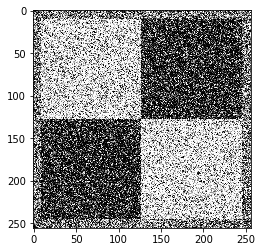

In [136]:
b,g,r = cv2.split(img_input_0_noise)
img_input_0_noise = cv2.merge([b,g,r])
plt.imshow(img_input_0_noise)

# Filter

In [137]:
img_input_0_noise_filtered = cv2.GaussianBlur(img_input_0_noise,(9,9),0)

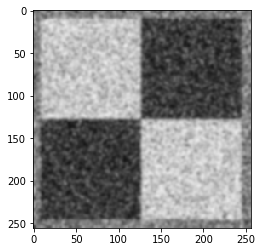

In [138]:
b,g,r = cv2.split(img_input_0_noise_filtered)
img_input_0_noise_filtered = cv2.merge([b,g,r])
plt.imshow(img_input_0_noise_filtered)

# Generate edge image

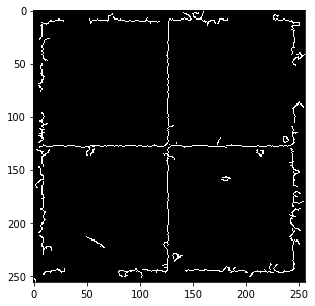

In [139]:
img_noise_edge = cv2.Canny(img_input_0_noise_filtered, 100, 200)
plt.subplots(figsize=(5, 5))
plt.imshow(img_noise_edge, cmap="gray")

# Get Hough Accumulator

In [140]:
h_noise = hough_lines_acc(img_noise_edge, img_input_0_noise_filtered)

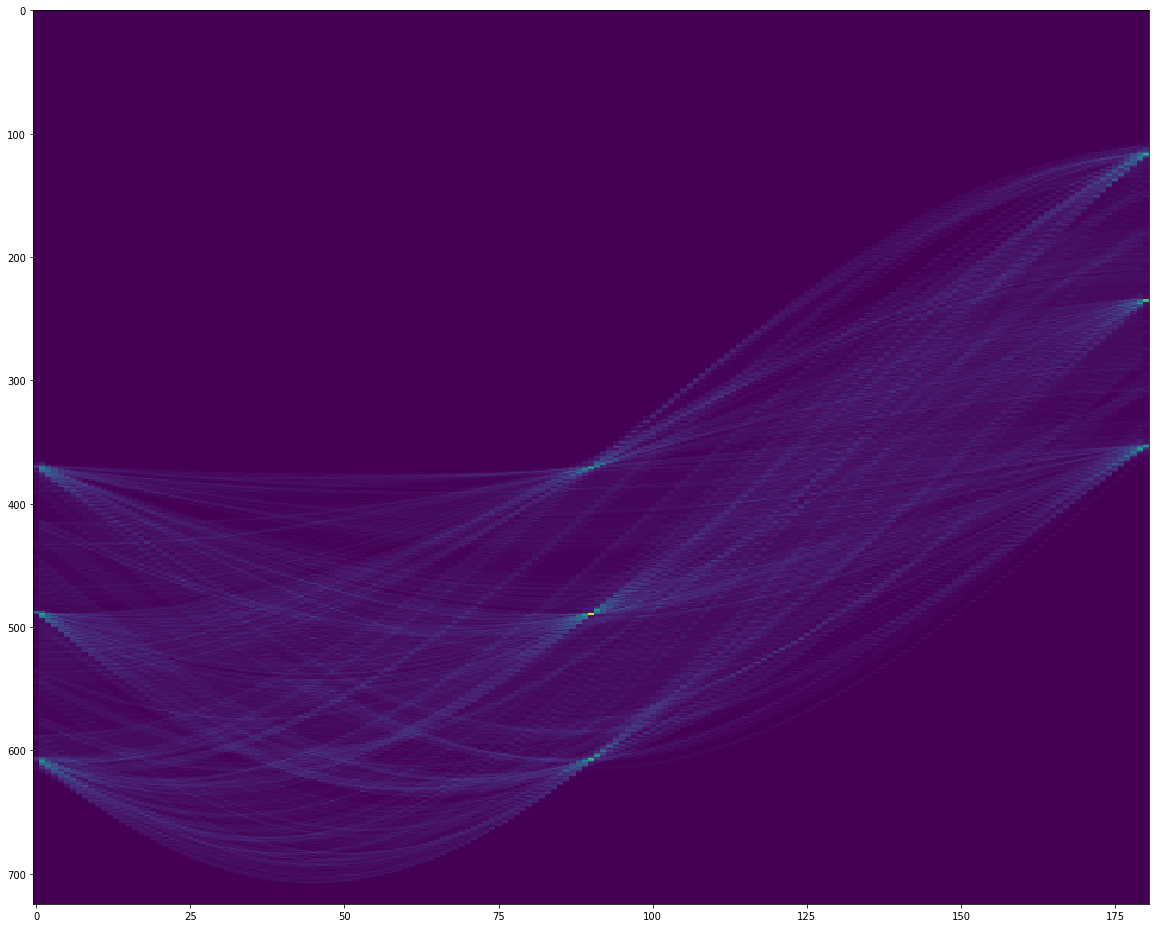

In [141]:
plt.subplots(figsize=(20, 20))
plt.imshow(h_noise, aspect=0.2)

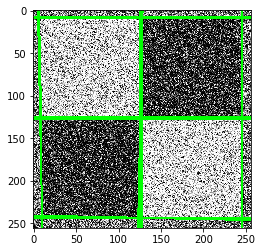

In [142]:
peaks_noise = hough_peaks(h_noise, 10)
result_noise_image = hough_lines_draw(img_input_0_noise, peaks_noise, int(h_noise.shape[0]/2))
plt.imshow(result_noise_image)

# Another image

In [143]:
img_input_1 = cv2.imread("C:/Users/edmundo/Downloads/ps1_matlab_template/input/ps1-input1.png")

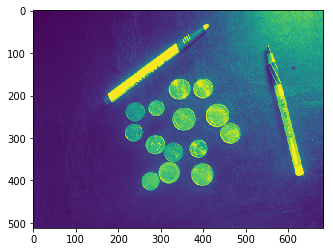

In [144]:
img_input_1_mon = cv2.cvtColor(img_input_1, cv2.COLOR_BGR2GRAY)
img_input_1_noise_filtered = cv2.GaussianBlur(img_input_1_mon,(3,3),0)
img_edge = cv2.Canny(img_input_1_noise_filtered, 100, 200)
plt.imshow(img_input_1_mon)

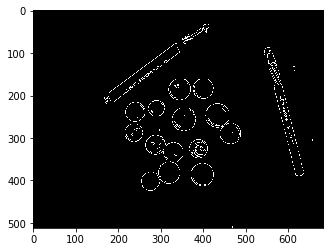

In [145]:
plt.imshow(img_edge, cmap="gray")

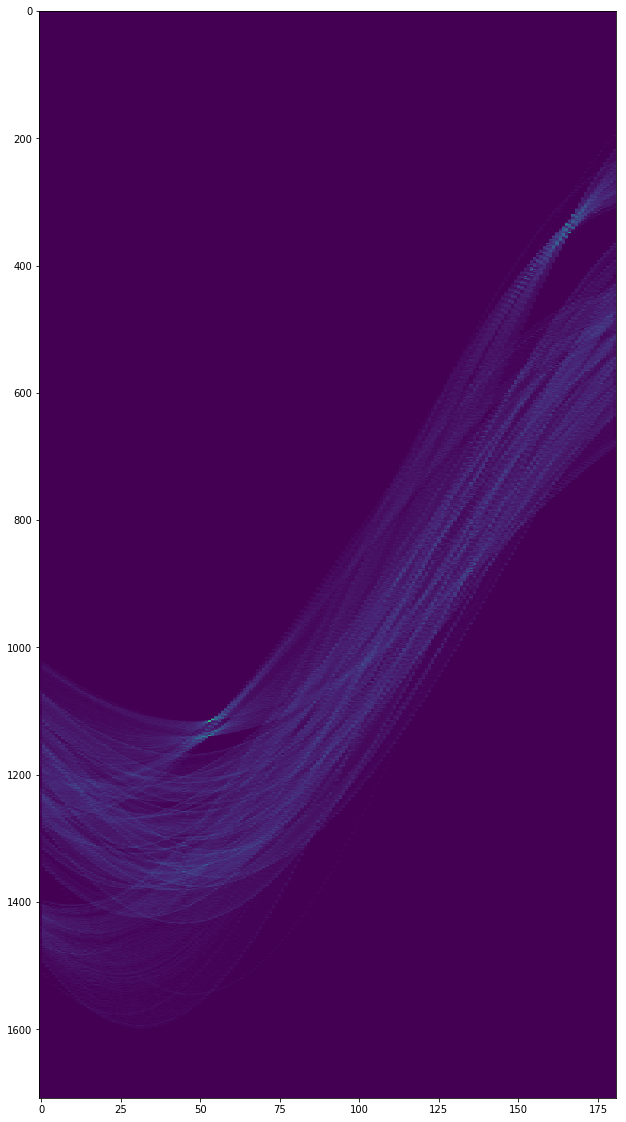

In [146]:
h_input_1 = hough_lines_acc(img_edge, img_input_1)
plt.subplots(figsize=(20, 20))
plt.imshow(h_input_1, aspect=0.2)

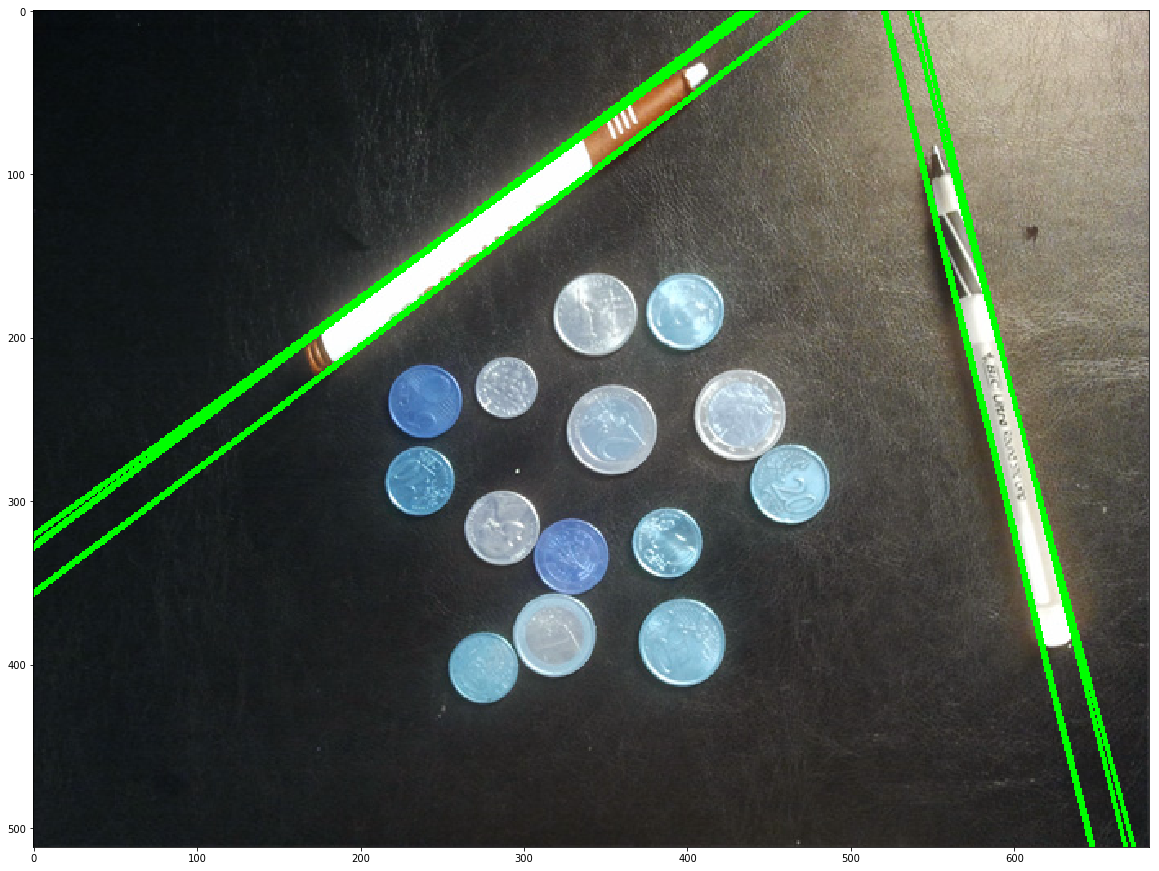

In [147]:
peaks_input_1 = hough_peaks(h_input_1, 10)
result_input_1 = hough_lines_draw(img_input_1, peaks_input_1, int(h_input_1.shape[0]/2))
plt.subplots(figsize=(20, 20))
plt.imshow(result_input_1)

# Define hough_circles_acc() function

In [148]:
def hough_circles_acc(img_edges, original_image, radius):
    height, width = img_edges.shape[:2]
        
    # Compute gradient with Sobel
    kernel_x = np.ones((3,3),np.float32)
    kernel_x[0] = [-1, 0, 1]
    kernel_x[1] = [-2, 0, 2]
    kernel_x[2] = [-1, 0, 1]
    
    kernel_y = np.ones((3,3),np.float32)
    kernel_y[0] = [1, 2, 1]
    kernel_y[1] = [0, 0, 0]
    kernel_y[2] = [-1, -2, -1]
    
    partial_x = cv2.filter2D(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), -1, kernel_x)
    partial_y = cv2.filter2D(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), -1, kernel_y)
    
    #partial_x = cv2.filter2D(img_edges, -1, kernel_x)
    #partial_y = cv2.filter2D(img_edges, -1, kernel_y)
    
    # Initialize the accumulator h(width, radius)
    h = np.zeros((height, width), dtype=np.uint8)
    
    """
    for y,x in np.ndindex(img_edges.shape):
        if img_edges[y][x]:
            if partial_x[y][x] == 0:
                theta = 90
                rad = theta*(np.pi/180)
            else:
                rad = np.arctan(partial_y[y][x] / partial_x[y][x])
                theta = rad*(180/np.pi)
            a = x - radius * np.cos(rad)
            b = y + radius * np.sin(rad)
            
            if a <= 0:
                a += radius
            else:
                a -= radius
                    
            if b <= 0:
                b += radius
            else:
                b -= radius
            
            h[int(b)][int(a)] += 1
    """      
    """
    for y,x in np.ndindex(img_edges.shape):
        if img_edges[y][x]:
            for theta in range(0, 360):
                rad = theta*(np.pi/180)
                a = x - radius * np.cos(rad)
                b = y + radius * np.sin(rad)
                
                if a <= 0:
                    a += radius
                else:
                    a -= radius
                    
                if b <= 0:
                    b += radius
                else:
                    b -= radius
                
                h[int(b)][int(a)] += 1
    """
    
    for y,x in np.ndindex(img_edges.shape):
        if img_edges[y][x]:
            if partial_x[y][x] == 0:
                theta = 90
                rad = theta*(np.pi/180)
            else:
                rad = np.arctan(partial_y[y][x] / partial_x[y][x])
                theta = rad*(180/np.pi)
            
            for theta_calc in range(int(theta), int(theta)+180):
                rad_calc = theta_calc*(np.pi/180)
                a = x - radius * np.cos(rad_calc)
                b = y + radius * np.sin(rad_calc)
                
                if a <= 0:
                    a += radius
                else:
                    a -= radius
                    
                if b <= 0:
                    b += radius
                else:
                    b -= radius
                
                h[int(b)][int(a)] += 1
    
            
    return h

(array([295, 305, 303, 211], dtype=int64), array([263, 366, 367, 270], dtype=int64))


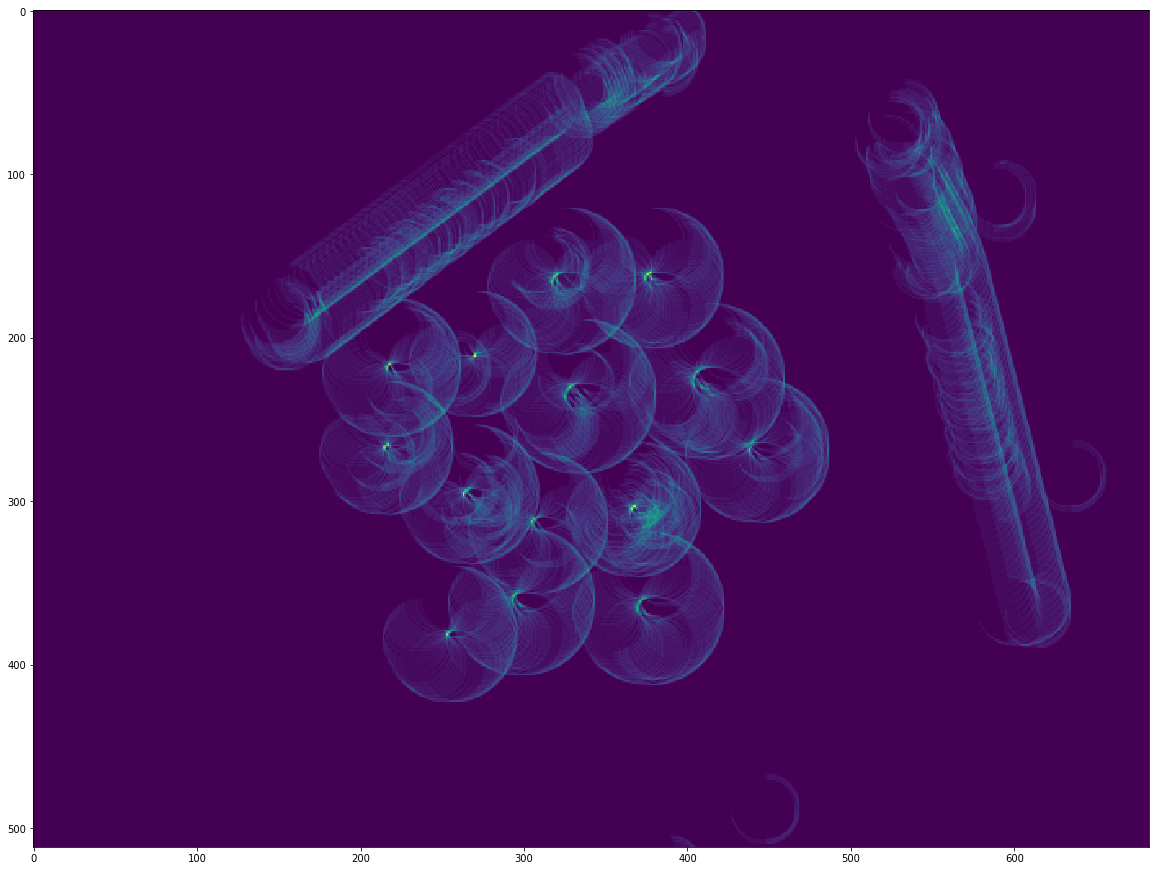

In [149]:
h = hough_circles_acc(img_edge, result_input_1, 20)
plt.subplots(figsize=(20, 20))
peaks = hough_peaks(h, 4)
print(peaks)
plt.imshow(h)

# find_circles() combines the two functions above

In [150]:
def find_circles(img_edges, original_image, radius_range):
    
    centers = []
    radii = []
    
    for radius in range(*radius_range):
        h = hough_circles_acc(img_edge, original_image, radius)
        peaks = hough_peaks(h, 2)
        
        for index,item in enumerate(peaks[0]):
            if item <= radius:
                b = item - radius
            else:
                b = item + radius

            if peaks[1][index] <= radius:
                a = peaks[1][index] - radius
            else:
                a = peaks[1][index] + radius
            
            centers.append((b,a))
            radii.append(radius)       
    
    return centers, radii

In [151]:
centers, radii = find_circles(img_edge, result_input_1, (20,30))

In [152]:
for index,center in enumerate(centers):
    cv2.circle(result_input_1, (center[1], center[0]), radii[index], (0,0,255), 2)

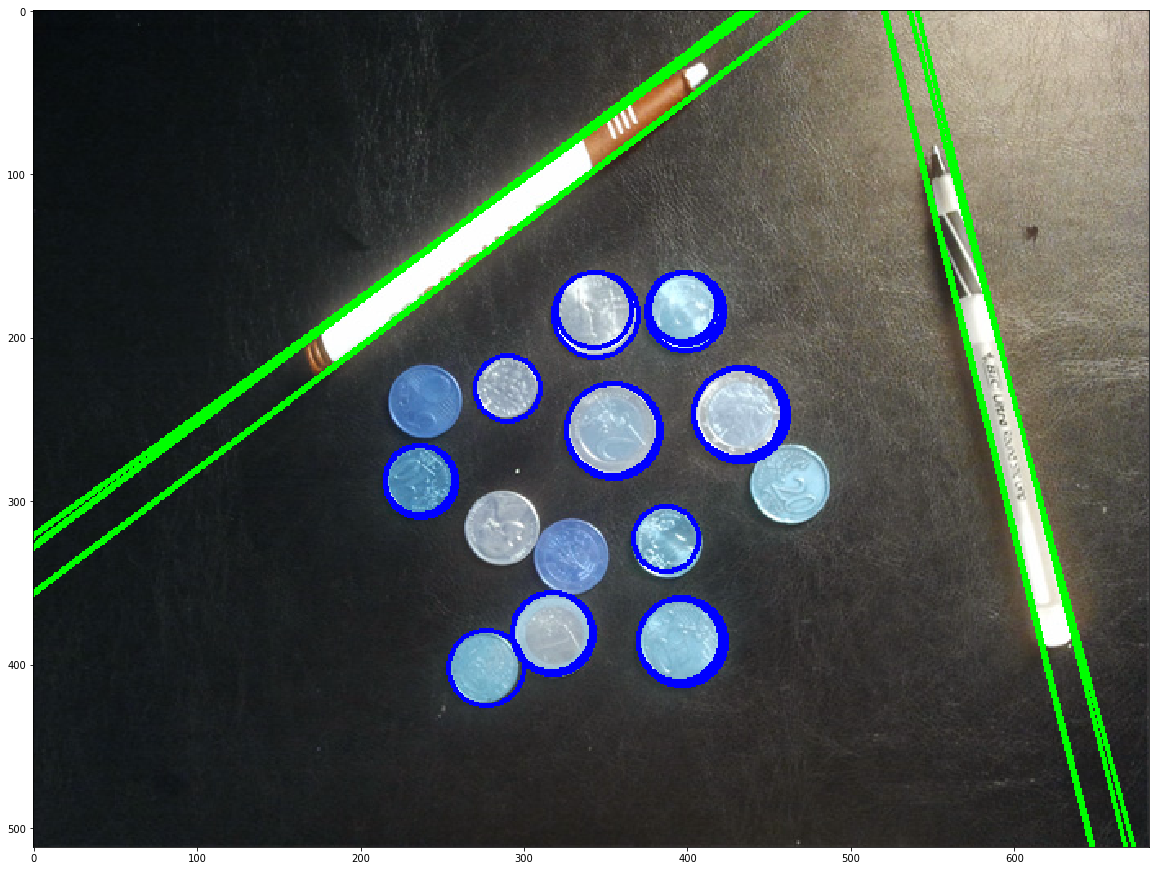

In [153]:
plt.subplots(figsize=(20, 20))
plt.imshow(result_input_1)